# GMODuck
A genetically modified yellow quantum duck who is competing in QHack 2021 Open Hackathon. This 🦆 is capable of building QML circuits using genetic programming without having any idea why his model works but he assures it's the best.

In a QML application, knowing what's the best Quantum circuit is a field of research. With this demo, 🦆 wants to jump that process and build a quantum circuit that successfully is the best one for its problem. At the moment, is problem is: properly classify a point in a 2D grid as either <span style="color:blue">blue</span> or <span style="color:orange">orange</span> based on a given dataset.

To to so, 🦆 is going to use genetic programming. Where the idea is to encode a quantum circuit in a string of zeros and ones that will represent the genome we want to evolve. So...

1. Create a genome that translates into a quantum circuit - different genes, encode different gates/templates
2. Randomly generate agents (agents are quantum circuits)
3. Train all agents and use area under ROC as fitness
4. Do "natural selection", cross between agents to create offspring and randomly mutate agents
5. Repeat for some generations until 🦆 has a satisfying classifier

First things first: let's install and import everything we need...

In [1]:
%%capture
!pip install pennylane
!pip install matplotlib
!pip install sklearn

# Imports
import random
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics

np.random.seed(42)

dev = qml.device('default.qubit', wires=2)

Before looking into the code, let's vizualise what this _encode a quantum circuit in a string of zeros and ones_ really means.

We want to have a bit in the string that represents the **encoding** of data, another one or the **circuit** we are trainning and a last one for the **measurment**. So, something like this:

In [2]:
genome = "101"
encoding_gene = genome[0]
circuit_gene  = genome[1]
measurment_gene  = genome[2]
print("Encoding:", encoding_gene, "\nCircuit:", circuit_gene, "\nMeasurement:", measurment_gene)

Encoding: 1 
Circuit: 0 
Measurement: 1


Now that we have the idea of what each gene in the genome represents, we can attribute functions to them. So, we want to look at a string, the genome, and transform it into a quantum circuit. Let's build that function!

In [3]:
def genome_to_circuit(genome, x, w):
    @qml.qnode(dev)
    def circuit(x,w):
        # Genes from genome
        encoding_gene = genome[0]
        circuit_gene  = genome[1]
        measurment_gene  = genome[2]
        
        # From gene, to quantum gate
        ## Encode data
        if encoding_gene == "0":
            qml.templates.AngleEmbedding(x, wires=[0, 1])
        elif encoding_gene == "1":
            qml.templates.IQPEmbedding(x, wires=[0, 1])
        
        ## Choose between basic entanglement and a more "complex" circuit with qubit Z, X rotationsa and CNOT operator
        if circuit_gene == "0":
            qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
        elif circuit_gene == "1":
            qml.RZ(w[0][0],wires=0)
            qml.RX(w[0][1],wires=1)
            qml.CNOT(wires=[0,1])
            qml.RZ(-1*w[0][0],wires=1)
            qml.RX(-1*w[0][1],wires=0)
        
        ## Measurement
        if measurment_gene == "0":
            measure = qml.PauliZ(wires=0)
        elif measurment_gene == "1":
            measure = qml.PauliY(wires=0)
        return qml.expval(measure)

    circuit(x,w)
    print(circuit.draw())
    return circuit(x,w)

In [4]:
# Some intial parameters to test quantum model
x = np.array([0.1, 0.2], requires_grad=False)
w = np.array([[-2.1, 1.2]])

genome_to_circuit(genome, x, w)

 0: ──H──RZ(0.1)──╭RZ(0.02)──RX(-2.1)──╭C──┤ ⟨Y⟩ 
 1: ──H──RZ(0.2)──╰RZ(0.02)──RX(1.2)───╰X──┤     



tensor(-0.05282549, requires_grad=True)

You can now test different genomes!

In [5]:
genome = "010"
genome_to_circuit(genome, x, w)

 0: ──RX(0.1)──RZ(-2.1)──╭C──RX(-1.2)──┤ ⟨Z⟩ 
 1: ──RX(0.2)──RX(1.2)───╰X──RZ(2.1)───┤     



tensor(0.36054748, requires_grad=True)

Now that we understood the core idea, we want to build quantum models from different _strings of zeros and ones_ (genome), evaluate the performance of each one and take advantage of genetic algorithms to cross between them, mutate , apply natural selection and hopefully, after some generations have our best model to solve our classification problem.

## Data

Let's see what's our dataset... Oh! It's <span style="color:blue">blue</span> and <span style="color:orange">orange</span> points as promised!

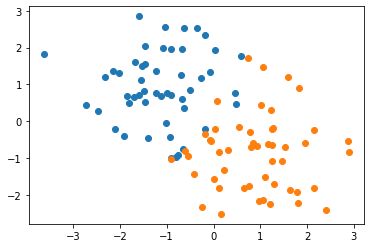

In [6]:
# This Data example is copied from the CERN workshop: https://indico.cern.ch/event/893116/

# You can change this parameters
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(int(n_samples/2)), np.ones(int(n_samples/2))], axis=0)
data = list(zip(X, Y))

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

# Split Data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)
data_train = list(zip(X_train, y_train))
data_test  = list(zip(X_test, y_test))

## Genetic Algorithm: Agents to evolve 

Now we build our Genetics part

In [7]:
# Init conditions
genome_type = '0101101101'
in_str_len = len(genome_type)

# You can tune this parameters
population = 6
generations = 9
threshold = 0.97

Let's create a class for the agents we want to evolve. We need 2 things in our agent: **genome** and **fitness**. The genome is going to be randomly generated each time an agent is created.

In [8]:
class Agent:
    def __init__(self, length):
        self.string = ''.join(str(random.randint(0,1)) for _ in range(length))
        self.fitness = -1

    def __str__(self):
        return ' String: ' + str(self.string) + ' Fitness: ' + str(self.fitness)

1. Create a population of agents
2. Evaluate the fitness of each one
3. Select between the best agents
4. Breed between them
5. Random mutate genes of the genome of the agent

In [9]:
def ga():
    agents = init_agents(population, in_str_len)
    
    for generation in range(generations):
        print("Generation: ", str(generation))
        
        agents = fitness(agents)
        agents = selection(agents)
        agents = crossover(agents)
        agents = mutation(agents)
        
        if any(agent.fitness >= threshold for agent in agents):
            print("\U0001F986 Thereshold has been met! Winning genome: ", agents[0].string)
            x = np.array([0.1, 0.2], requires_grad=False)
            w = np.array([[1.1, -2], [2, -1], [-2, 1]])
            a_more_complicated_genome_to_circuit(agents[0].string, x, w, True)
            break

## Create a population of agents

In [10]:
def init_agents(population, length):
    return [Agent(length) for _ in range(population)]

## Fitness and definition of Quantum Model

This is the part where we build our quantum model from a gene, train it and evaluate it based on the area under the ROC. This value is going to correspond to the fitness of the agent.

In [11]:
def a_more_complicated_genome_to_circuit(genome, x, w, verbose):
    @qml.qnode(dev)
    def circuit(x,w):
        # Encoding
        encode_gene = genome[:2]
        if encode_gene == "00":
            qml.templates.AngleEmbedding(x, wires=[0, 1])
        elif encode_gene == "01":
            qml.templates.AmplitudeEmbedding(x, wires=[0, 1],pad=1,normalize=True)
        elif encode_gene == "10" or "11":
            qml.templates.IQPEmbedding(x, wires=[0, 1])

        RZ_gene = genome[2:4]
        if RZ_gene == "01":
            qml.RZ(0.1,wires=0)
        elif RZ_gene == "10":
            qml.RZ(0.1,wires=1)
        elif RZ_gene == "11":
            qml.RZ(0.1,wires=0)
            qml.RZ(0.1,wires=1)

        Entanglement_gene = genome[4:5]
        if Entanglement_gene == "0":
            qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
        elif Entanglement_gene == "1":
            qml.RZ(w[0][0],wires=0)
            qml.RX(w[0][1],wires=1)
            qml.CNOT(wires=[0,1])
            qml.RZ(-1*w[1][0],wires=1)
            qml.RX(-1*w[1][1],wires=0)
            qml.CNOT(wires=[0,1])
            qml.RY(w[2][0],wires=0)
            qml.RX(-1*w[2][1],wires=1)

        T_gene = genome[5:7]
        if T_gene == "01":
            qml.T(wires=0)
        elif T_gene == "10":
            qml.T(wires=1)
        elif T_gene == "11":
            qml.T(wires=0)
            qml.T(wires=1)

        CNOT_gene = genome[7:8]
        if CNOT_gene == "1":
            qml.CNOT(wires=[0,1])

        measurment_gene = genome[8:10]
        if measurment_gene == "00" or "11":
            measure = qml.PauliZ(wires=0)
        elif measurment_gene == "01":
            measure = qml.PauliY(wires=0)
        elif measurment_gene == "10":
            measure = qml.PauliX(wires=0)
                
        return qml.expval(measure)
    
    circuit(x,w)
    
    if verbose:
        print(circuit.draw())
    else:
        return circuit(x,w)

To better understand the training part with plots and validation, check the `one_quantum_model.ipynb` jupyter notebook in the same repo.

In [12]:
def fitness(agents):
    for agent in agents:
        global genome
        genome = agent.string
      
        # Cost function
        def loss(a, b):
            return (a - b)**2

        def average_loss(w, data):
            c = 0
            for x, y in data:
                #prediction = quantum_model(x, w)
                prediction = a_more_complicated_genome_to_circuit(genome, x, w, False)
                c += loss(prediction, y)
            return c/len(data)

        # Gradient
        gradient_fn = qml.grad(average_loss, argnum=0)

        # Trainning
        w_init = np.array([[1.1, -2], [2, -1], [-2, 1]])

        w = np.array(w_init)

        history = []

        # You can tune this parameter
        for i in range(5):
            w_new = w - 0.3*gradient_fn(w, data_train)
            avg_loss = average_loss(w_new, data_train)
            history.append(w_new)
            w = w_new

        def pred(w,X):
            y_pred = []
            for x in X:
                #prediction = quantum_model(x, w)
                prediction = a_more_complicated_genome_to_circuit(genome, x, w, False)
                y_pred.append(prediction)
            return y_pred

        y_pred_train = pred(w,X_train)
        y_pred_test  = pred(w,X_test)
        fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)

        roc_auc_train = metrics.auc(fpr_train,tpr_train)
        roc_auc = metrics.auc(fpr,tpr)
        
        agent.fitness = roc_auc
    return agents

## Selection

In [13]:
def selection(agents):
    agents = sorted(agents, key=lambda agent: agent.fitness, reverse=True)
    print('\n'.join(map(str, agents)))

    # Natural selection
    kill_param = 0.2 # take the top 20% of the individuals
    agents = agents[:int(kill_param * len(agents))]
    return agents

## Cross over

In [14]:
def crossover(agents):
    offspring = []

    for _ in range( int((population - len(agents))/2)):
        # TODO: don't breed parents that are the same
        parent1 = random.choice(agents)
        parent2 = random.choice(agents)

        child1 = Agent(in_str_len)
        child2 = Agent(in_str_len)
        split = random.randint(0,in_str_len)
        child1.string = parent1.string[0:split] + parent2.string[split:in_str_len]
        child2.string = parent2.string[0:split] + parent1.string[split:in_str_len]

        offspring.append(child1)
        offspring.append(child2)

    agents.extend(offspring)
    return agents

## Mutation

In [15]:
def mutation(agents):
    chance_of_mutation = 0.20
    for agent in agents:
        for idx, param in enumerate(agent.string):
            if random.uniform(0.0,1.0) <= chance_of_mutation:
                agent.string = agent.string[0:idx] + str(random.randint(0,1)) + agent.string[idx+1:in_str_len]
    return agents

## Run the genetic algorithm 

In [16]:
ga()

Generation:  0
 String: 0000011011 Fitness: 0.9196428571428572
 String: 1110011001 Fitness: 0.8125
 String: 1000010100 Fitness: 0.8125
 String: 1111010010 Fitness: 0.7946428571428571
 String: 0111011000 Fitness: 0.75
 String: 0110010101 Fitness: 0.7232142857142857
Generation:  1
 String: 0000111010 Fitness: 0.9285714285714286
 String: 0000011011 Fitness: 0.9196428571428572
 String: 0000011011 Fitness: 0.9196428571428572
 String: 0000011011 Fitness: 0.9196428571428572
 String: 0010011011 Fitness: 0.9017857142857142
Generation:  2
 String: 0010111110 Fitness: 0.9330357142857143
 String: 0000111010 Fitness: 0.9285714285714286
 String: 0000111010 Fitness: 0.9285714285714286
 String: 0000111010 Fitness: 0.9285714285714286
 String: 0000011010 Fitness: 0.9196428571428572
Generation:  3
 String: 0110111110 Fitness: 0.9821428571428572
 String: 0010111110 Fitness: 0.9330357142857143
 String: 0010111110 Fitness: 0.9330357142857143
 String: 0010111111 Fitness: 0.9330357142857143
 String: 001101111

In [17]:
print("\U0001F986 Qhack Qhack") 

🦆 Qhack Qhack
